# 06 Plots

In this notebook, we generate some of the plots that are presented in the paper.

### Contents:
1. Set up
2. Validation plots  
2.1. Calibration plot  
2.2. CR2 generalization scatter plots  
2.3. Histogram for CR2 scores  
3. Ranking plots  
3.1. GI rankings  
3.2. TC rankings  
4. Cell search plots  
4.1. Feature importance barplot  
4.2. Cell overlap plots

In [1]:
# Standard imports
import numpy as np
import pandas as pd
from scipy import stats
import sys
import copy
import random
import joblib

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import pylab

In [15]:
# Global plot style settings
plt.style.use("fivethirtyeight")
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = 20
pylab.rcParams['xtick.major.pad'] = 5
pylab.rcParams['ytick.major.pad'] = 5
mpl.rcParams["figure.figsize"] = [8, 6]
mpl.rcParams['savefig.transparent'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.edgecolor'] = 'black'
# plt.rcParams['patch.edgecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
# plt.rcParams['grid.color'] = 'black'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Save settings
#SAVE_PATH  = f"figs/{outcome_name}/"
savfig = False

In [4]:
# Load the fitted libraries
fitted_libraries = joblib.load(f"data_files/{outcome_name}/{outcome_name}_fitted_libraries")

## 2. Validation plots

### 2.1. Calibration plot

In [5]:
cal_plot_data = joblib.load(f"data_files/GI/GI_calplotdata")

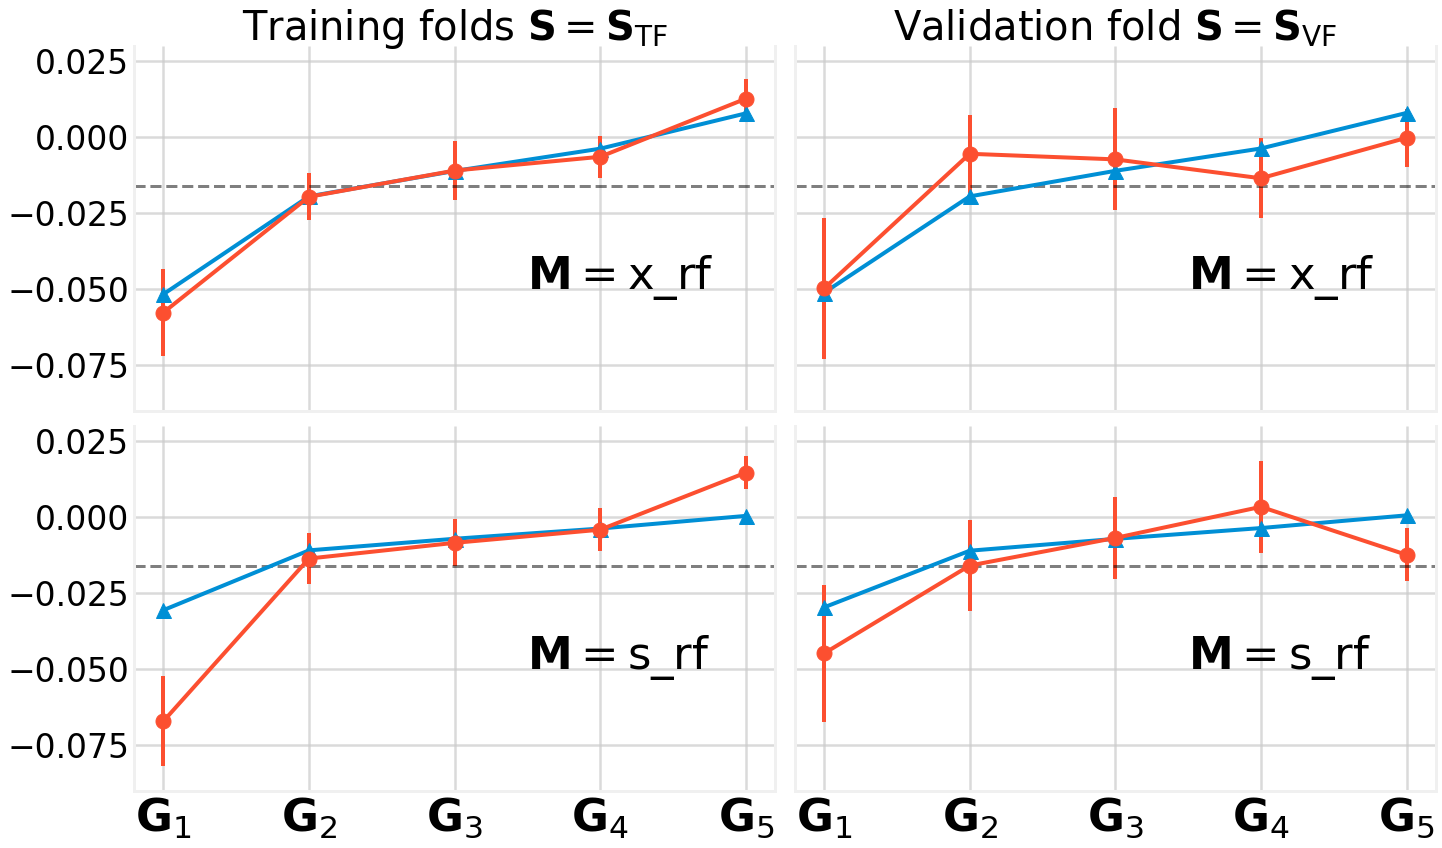

In [10]:
n_bins = 5
ATE = -0.01619

label_size = 35
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = 33
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size

xticks = ['[0.,.2]', '[.2,.4]', '[.4,.6]', '[.6,.8]', '[.8,1]']
xticks = [r'$\mathbf{G}_%d$'%j for j in range(1,6)]
fig, axes = plt.subplots(2, 2, sharey = True, sharex=True, figsize = [20, 12])
axes = axes.flatten()
for j, estimator in enumerate(['x_rf', 's_rf']):
    ax1, ax2 = axes[2*j], axes[2*j+1]
    for k, (lab, title, ax) in enumerate(zip(["train", "val"], 
                                             [r"Training folds $\mathbf{S} = \mathbf{S}_{\mathrm{TF}}$", 
                                              "Validation fold $\mathbf{S} = \mathbf{S}_{\mathrm{VF}}$"], 
                                             [ax1 ,ax2])):
        if j == 0:
            ax.set_title(title, fontsize=40)
        # Plot model CATEs
        p1 = ax.errorbar(x = np.arange(0, n_bins), 
                    y = cal_plot_data[k][estimator]["model_CATEs"], 
                    yerr = cal_plot_data[k][estimator]["model_CATEs_std"],
                    marker= '^', markersize = 15, #color = "red",
                    linewidth = 4., 
                    )
        # Plot Neyman CATEs
        p2 = ax.errorbar(x = np.arange(0, n_bins), 
                    y = cal_plot_data[k][estimator]["Neyman_CATEs"],
                    yerr = cal_plot_data[k][estimator]["Neyman_CATEs_std"],
                    marker = 'o', markersize = 15, #color = "blue",
                    linewidth = 4., 
                    )
        ax.text(x=2.5, y=-0.05, s= r'$\mathbf{M}=$' + estimator, fontsize=45)
        # Add line to indicate ATE
        ax.axhline(y = ATE, linestyle='--', color = 'k', linewidth = 3., alpha = 0.5)
        ax.set_ylim([-0.09, 0.03])
#         ax.text(x=0.1, y=0.03, s= r'$\mathbf{M}=$ ' + new_labels_dict[estimator], fontsize=label_size)
#         # Add line to indicate ATE
#         ax.axhline(y = ATE, linestyle='--', color = 'k', linewidth = 3., alpha = 0.5)
        # X labels and legend
        if j == 1:
            ax.set_xticks(np.arange(0, n_bins))
#             ax.set_xticklabels(cal_plot_data[k][estimator].index)
            ax.set_xticklabels(xticks, fontsize=45)
#             ax.set_xlabel(r"q value range for $\mathcal{G}$")

            
        ax.grid(True, alpha = 0.7)
#         ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
#         ax.spines['bottom'].set_visible(False)
# plt.suptitle("TC Events", y=1.01)
plt.tight_layout()
leg = fig.legend((p1, p2), (r'$\overline{\mathbf{M}}_{\mathbf {G} \cap \mathbf{S}}$', 
                            r'$\widehat{\tau}_{\mathbf{G}\cap \mathbf{S}}$'), 'center right', bbox_to_anchor=(0.4, 0.48), fontsize=45,
          frameon=True)

if savfig:
    plt.savefig(SAVE_PATH + "GI_x_rf_s_rf_calibration_plot.pdf"
                , bbox_inches='tight'
               )
leg.remove()

if savfig:
    plt.savefig(SAVE_PATH + "GI_x_rf_s_rf_calibration_plot_no_leg.pdf"
                , bbox_inches='tight'
               )

plt.show()

### 2.2. CR2 generalization scatter plots

In [13]:
selected_estimators = ["s_rf", "t_rf", "x_rf", "r_rfrf", "causal_forest_1"]
new_labels = ["T_RF", "S_RF", "X_RF","R_RFRF", "CF_1"]
new_labels = ["t_rf", "s_rf", "x_rf","r_rfrf", "cf"]
new_labels_dict = dict(zip(selected_estimators, new_labels))

fold_no = 0 

In [17]:
[gi_5r_plot_data, gi_2r_plot_data] = joblib.load("data_files/GI/GI_rscores")
[cr2_5r_plot_data, cr2_2r_plot_data] = joblib.load("data_files/cfd_cardio/cfd_cardio_rscores")

label_size = 30
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size

mss = ['X', 'o', '*', 'D', '+']
ms_size = [200, 150, 300, 120, 200]

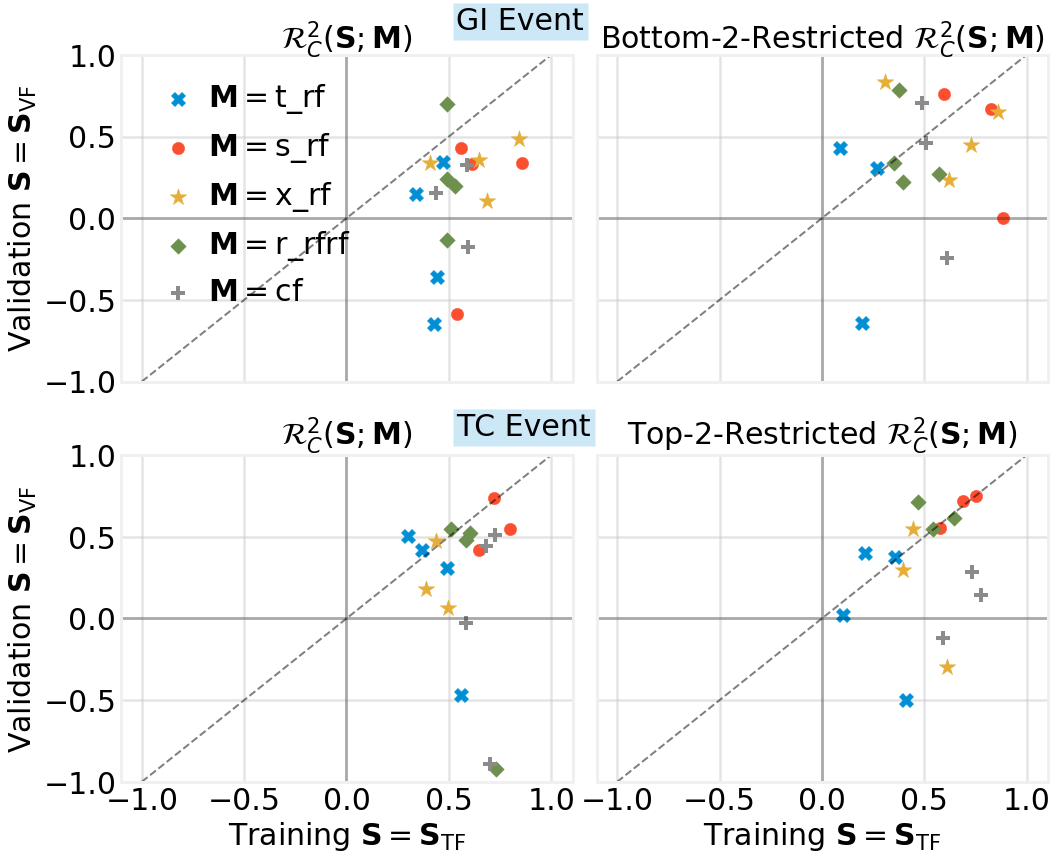

In [18]:
## scatter plot for TC and GI together
f, axes = plt.subplots(2, 2, sharey = True, sharex = True, figsize = [15, 12])

axes = axes.flatten()
for j, (ax, est5_cr_scores, title) in enumerate(zip([axes[0], axes[1], axes[2], axes[3]], 
                                                [gi_5r_plot_data, gi_2r_plot_data,
                                                 cr2_5r_plot_data, cr2_2r_plot_data,
                                                ],
                                                 [r"$\mathcal{R}_C^2(\mathbf{S}; \mathbf{M})$", r"Bottom-2-Restricted $\mathcal{R}_C^2(\mathbf{S}; \mathbf{M})$",
                                                 r"$\mathcal{R}_C^2(\mathbf{S}; \mathbf{M})$", r"Top-2-Restricted $\mathcal{R}_C^2(\mathbf{S}; \mathbf{M})$",
                                                 ]
                                                )):

    for i, estimator in enumerate(selected_estimators):
        ax.scatter(est5_cr_scores[estimator]["cr2_train"], 
                    est5_cr_scores[estimator]["cr2_val"], 
                    label = r"$\mathbf{M}=$" +new_labels_dict[estimator], marker = mss[i], s=ms_size[i])
    ax.plot([-1, 1], [-1, 1], 'k--', alpha = 0.5, linewidth = 2.)
    ax.axhline(y = 0, color = 'k', alpha = .25, linewidth=3)
    ax.axvline(x = 0, color = 'k', alpha = .25, linewidth=3)
    if j%2==0:
        ax.set_ylabel(r"Validation $\mathbf{S} = \mathbf{S}_{\mathrm{VF}}$")
    if j >1 :
        ax.set_xlabel(r"Training $\mathbf{S} = \mathbf{S}_{\mathrm{TF}}$")
    ax.set_title(title, fontsize=30)
    ax.grid(True, alpha = 0.5)
    if j == 0:
        ax.legend(loc="upper left", fontsize=30, 
                  handletextpad=0,
                  frameon=False)

    ax.set_ylim([-1, 1])

plt.gcf().text(0.43, 0.50, 'TC Event', fontsize=30, bbox=dict(facecolor=colors[0],alpha=0.2))
plt.gcf().text(0.43, 0.97, 'GI Event', fontsize=30,  bbox=dict(facecolor=colors[0],alpha=0.2))
plt.tight_layout()
suptitle = plt.suptitle(r"Scatter plot of $\mathcal{R}_C^2(\mathbf{S}; \mathbf{M})$-Scores", x=0.55, y=1.05, fontsize=35)

savfig = False
if savfig:
    plt.savefig(f"figs/GI_TC_scatter_r2.pdf", bbox_inches='tight')
suptitle.remove()

if savfig:
    plt.savefig(f"figs/GI_TC_scatter_r2_no_sup.pdf")

plt.show()

### 2.3. Histogram for CR2 scores

In [19]:
[gi_cr_train, gi_cr_val] = joblib.load(f"data_files/GI/GI_rscores_hist")
[tc_cr_train, tc_cr_val] = joblib.load(f"data_files/cfd_cardio/cfd_cardio_rscores_hist")

In [21]:
label_size = 25
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size

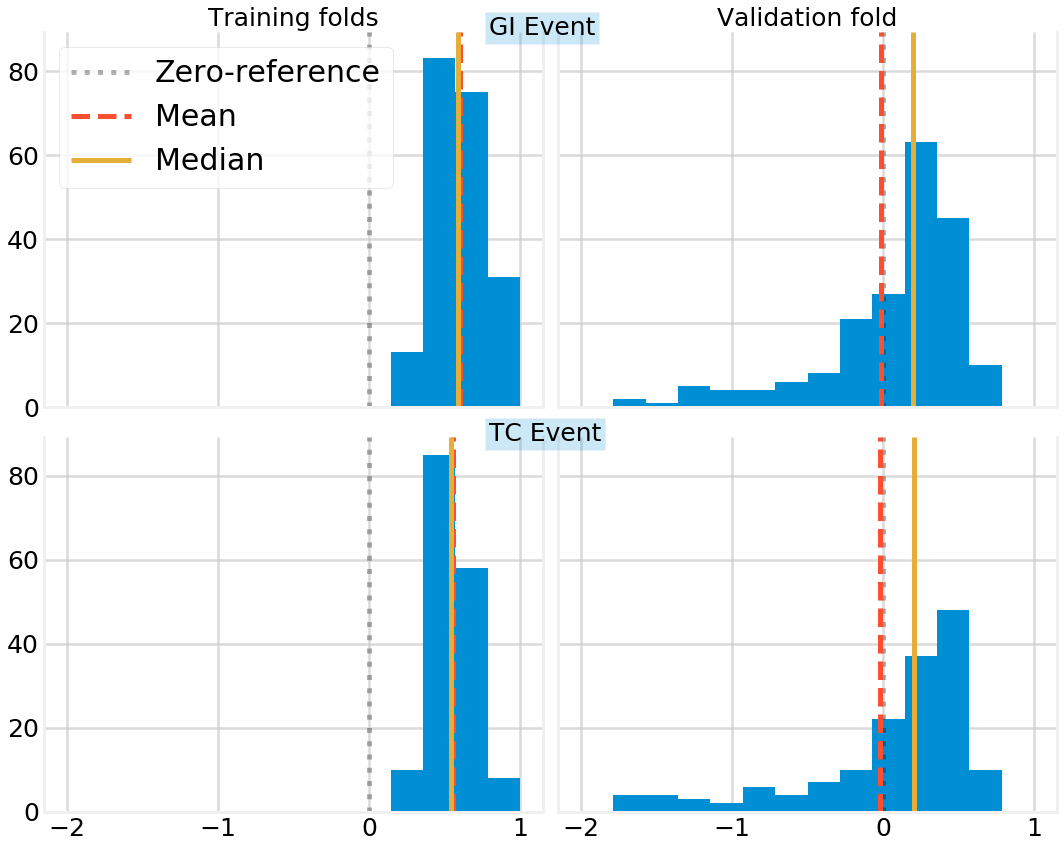

In [23]:
savfig = False
f, axes = plt.subplots(2, 2, sharey = True, sharex = True, figsize = [15, 12])

axes = axes.flatten()
ax = axes[0]
for j, (ax, all_cr_scores, title) in enumerate(zip([axes[0], axes[1], axes[2], axes[3]], 
                                                [gi_cr_train, gi_cr_val,
                                                tc_cr_train, tc_cr_val],
                                                 ["Training folds", "Validation fold"]*2
                                                )):
    ax.hist(all_cr_scores, bins = np.linspace(-2,1,15))
    ax.axvline(0, alpha=.3, color='k', linestyle=':',linewidth=5.,
               label="Zero-reference")
    ax.axvline(all_cr_scores.mean(), linestyle='--', color=colors[1], alpha=1,linewidth=5.,
                label="Mean")
    ax.axvline(all_cr_scores.median(), linestyle='-', color=colors[2], alpha=1.,linewidth=5.,
                label="Median")
    if j <2:
        ax.set_title(title)
    if j == 0:
        ax.legend(fontsize=30)
    ax.grid(True, alpha = 0.7)
    ax.spines['top'].set_visible(False)
    
plt.tight_layout()
plt.gcf().text(0.46, 0.48, 'TC Event', fontsize=25, bbox=dict(facecolor=colors[0],alpha=0.2))
plt.gcf().text(0.46, 0.95, 'GI Event', fontsize=25,  bbox=dict(facecolor=colors[0],alpha=0.2))

# plt.suptitle(r"Histogram of $\mathfrak{R}_C^2$-Scores for GI Events",  y=1.0)
# if savfig:
#     plt.savefig(SAVE_PATH + f"{outcome_name}_distribution_r2.pdf")
plt.show()

### 2.4. Monotonicity box plots

In [25]:
GI_new_monotonicity_df = joblib.load("data_files/GI/GI_new_monotonicity_df")
GI_monotonicity_df = joblib.load("data_files/GI/GI_monotonicity_df")
TC_new_monotonicity_df = joblib.load("data_files/cfd_cardio/cfd_cardio_new_monotonicity_df")
TC_monotonicity_df = joblib.load("data_files/cfd_cardio/cfd_cardio_monotonicity_df")

In [26]:
label_size = 22
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size

In [27]:
stick = 'A'
ticks1 = [r'$\overline{%s}_{%d,%d}$'%(stick, i, i+1) for i in range(1, 5)]
ticks1.append(r'$\overline{%s}_{1,\min}$'%(stick))

ticks2 = [r'$\overline{%s}_{%d,%d}$'%(stick, i, i+1) for i in range(1, 5) ]
ticks2.append(r'$\overline{%s}_{5,\max}$'%(stick))

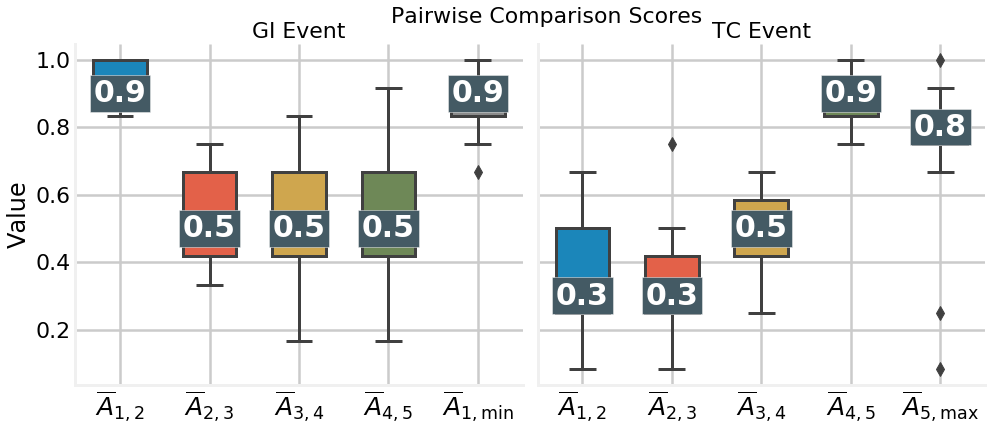

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = [14, 6])

ax= ax1
box_plot = sns.boxplot(data=GI_monotonicity_df.drop(index=["mean", "top6_mean"]), 
                       ax=ax, fliersize=10, linewidth=3, width=.6)

######## adding median values to the plot #########
x = box_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()
for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0],1) 
    ax.text(
        cat, 
        y, f'{y}',  ha='center', va='center',  fontweight='bold', 
        size=30, color='white', bbox=dict(facecolor='#445A64'))
    
######## changing the ticks ########
ax.set_xticklabels(ticks1, fontsize=25)
ax.grid(True)
ax.set_title("GI Event")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax= ax2
box_plot = sns.boxplot(data=TC_monotonicity_df.drop(index={"mean","top5_mean"}), 
                       ax=ax, fliersize=10, linewidth=3, width=.6)

######## adding median values to the plot #########
x = box_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()
for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0],1) 
    ax.text(
        cat, 
        y, f'{y}',  ha='center', va='center',  fontweight='bold', 
        size=30, color='white', bbox=dict(facecolor='#445A64'))
    
######## changing the ticks ########
ax.set_xticklabels( ticks2, fontsize=25)
ax.grid(True)
ax.set_title("TC Event")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

ax1.set_ylabel("Value", fontsize=24)
plt.suptitle("Pairwise Comparison Scores", x=.55, y=1.0)
plt.tight_layout()

savfig = False
if savfig:
    plt.savefig("figs/GI_TC_monotonicity_box_plot.pdf")
plt.show()

In [29]:
stick = 'B'
qs = [0.1, 0.2, 0.3, 0.4, 0.5]
ticks1 = [r'$\overline{%s}_{%.1f}$'%(stick, q) for q in qs]
ticks2 = [r'$\overline{%s}_{%.1f}$'%(stick, 1-q) for q in qs]

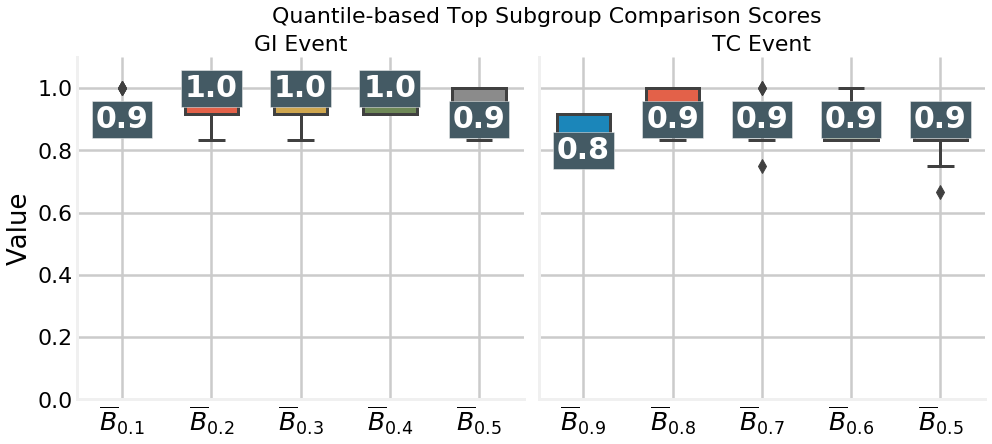

In [30]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = [14, 6])

ax= ax1
box_plot = sns.boxplot(data=GI_new_monotonicity_df.drop(index=["mean", "top6_mean"]), 
                       ax=ax, fliersize=10, linewidth=3, width=.6)

######## adding median values to the plot #########
x = box_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()
for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0],1) 
    ax.text(
        cat, 
        y, f'{y}',  ha='center', va='center',  fontweight='bold', 
        size=30, color='white', bbox=dict(facecolor='#445A64'))
    
######## changing the ticks ########
ax.set_ylim([0, 1.1])
ax.set_xticklabels(ticks1, fontsize=25)
ax.grid(True)
ax.set_title("GI Event")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax= ax2
box_plot = sns.boxplot(data=TC_new_monotonicity_df.drop(index={"mean","top5_mean"}), 
                       ax=ax, fliersize=10, linewidth=3, width=.6)

######## adding median values to the plot #########
x = box_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()
for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0],1) 
    ax.text(
        cat, 
        y, f'{y}',  ha='center', va='center',  fontweight='bold', 
        size=30, color='white', bbox=dict(facecolor='#445A64'))
    
######## changing the ticks ########
ax.set_xticklabels( ticks2, fontsize=25)
ax.grid(True)
ax.set_title("TC Event")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

ax1.set_ylabel("Value", fontsize=26)
plt.suptitle("Quantile-based Top Subgroup Comparison Scores", x=.55, y=1.03)
plt.tight_layout()

savfig = False
if savfig:
    plt.savefig("figs/GI_TC_new_monotonicity_box_plot.pdf", bbox_inches='tight')
plt.show()

## 3. Ranking plots

In [33]:
GI_results_df, GI_ranking_df = joblib.load("data_files/GI/GI_t_boxplot_data")
TC_results_df, TC_ranking_df = joblib.load("data_files/cfd_cardio/cfd_cardio_t_boxplot_data")

In [26]:
# Plot style settings
plt.style.use("fivethirtyeight")
label_size = 23
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = 20
pylab.rcParams['xtick.major.pad'] = 5
pylab.rcParams['ytick.major.pad'] = 5
mpl.rcParams["figure.figsize"] = [8, 6]
mpl.rcParams['savefig.transparent'] = True


plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.edgecolor'] = 'black'
# plt.rcParams['patch.edgecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
# plt.rcParams['grid.color'] = 'black'

## 3.1. GI rankings

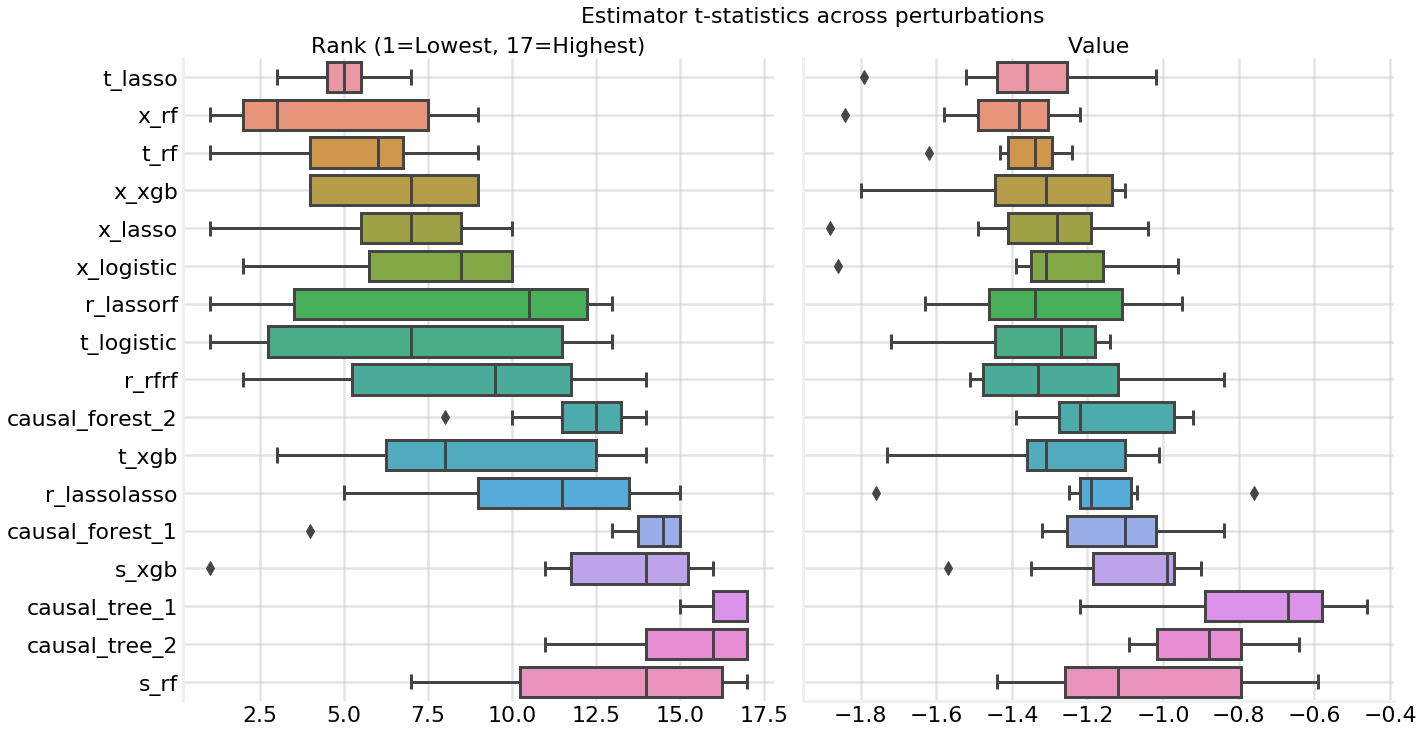

In [35]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=[20, 10])

ax = axes[0]
box_plot = sns.boxplot(data = GI_ranking_df.T, orient='h',
                       fliersize=10, linewidth=3, ax=ax)
ax.set_ylabel('')
ax.set_title("Rank (1=Lowest, 17=Highest)", x=0.5, y=1)
ax.grid(True, alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# ax.set_xlabel("Value")

ax = axes[1]
box_plot = sns.boxplot(data = GI_results_df.reindex(index=GI_ranking_df.index).T, 
                       orient='h',fliersize=10, linewidth=3, ax=ax)
ax.set_ylabel('')
ax.set_title("Value", y=1)
ax.grid(True,  alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.set_xlabel("Value")
plt.tight_layout()
plt.suptitle("Estimator t-statistics across perturbations", x=0.57, y=1.02)

savfig = False
if savfig:
    plt.savefig(SAVE_PATH + "GI_scores_rank_estimators.pdf",bbox_inches='tight')
plt.show()
# sns.boxplot(data=monotonicity_df, ax=ax, fliersize=10, linewidth=3)


### 3.2. TC rankings

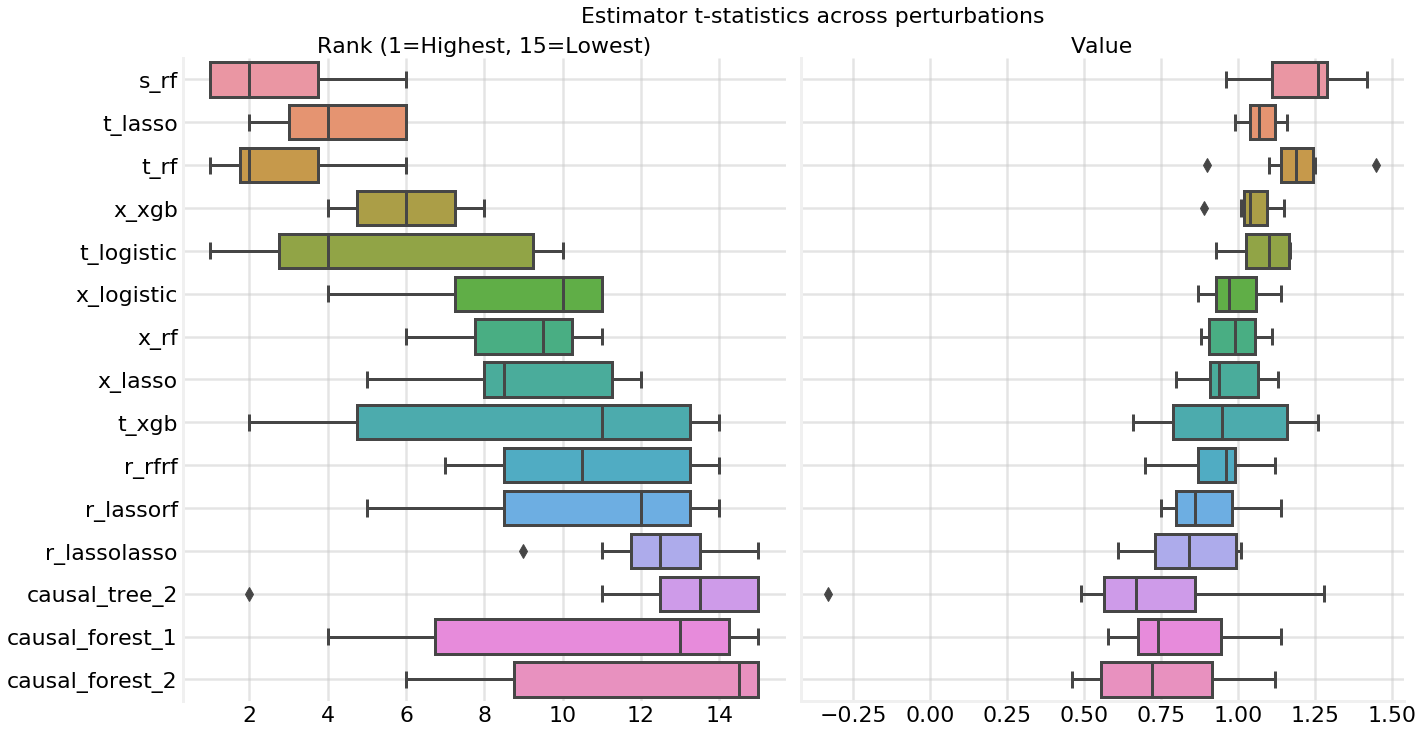

In [36]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=[20, 10])

ax = axes[0]
box_plot = sns.boxplot(data=TC_ranking_df.T, orient='h',fliersize=10, 
                       linewidth=3, ax=ax)
ax.set_ylabel('')
ax.set_title("Rank (1=Highest, 15=Lowest)", x=0.5, y=1)
ax.grid(True, alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# ax.set_xlabel("Value")

ax = axes[1]
box_plot = sns.boxplot(data=TC_results_df.reindex(index=TC_ranking_df.index).T, 
                       orient='h',fliersize=10, linewidth=3, ax=ax)
ax.set_ylabel('')
ax.set_title("Value", y=1)
ax.grid(True,  alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.set_xlabel("Value")
plt.tight_layout()
plt.suptitle("Estimator t-statistics across perturbations", x=0.57, y=1.02)

savfig = False
if savfig:
    plt.savefig(SAVE_PATH + "cfd_cardio_scores_rank_estimators.pdf", 
                bbox_inches='tight')
plt.show()
# sns.boxplot(data=monotonicity_df, ax=ax, fliersize=10, linewidth=3)

## 4. Cell search plots

### 4.1. Feature importance barplot

In [30]:
# Plot style settings
plt.style.use("fivethirtyeight")
label_size = 22
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = 20
pylab.rcParams['xtick.major.pad'] = 5
pylab.rcParams['ytick.major.pad'] = 5
mpl.rcParams["figure.figsize"] = [8, 6]
mpl.rcParams['savefig.transparent'] = True

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.edgecolor'] = 'black'
# plt.rcParams['patch.edgecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
# plt.rcParams['grid.color'] = 'black'
SAVE_PATH  = f"figs/{outcome_name}/"

In [37]:
GI_feat_imp = joblib.load(f"data_files/GI/GI_feat_imp")
TC_feat_imp = joblib.load(f"data_files/cfd_cardio/cfd_cardio_feat_imp")

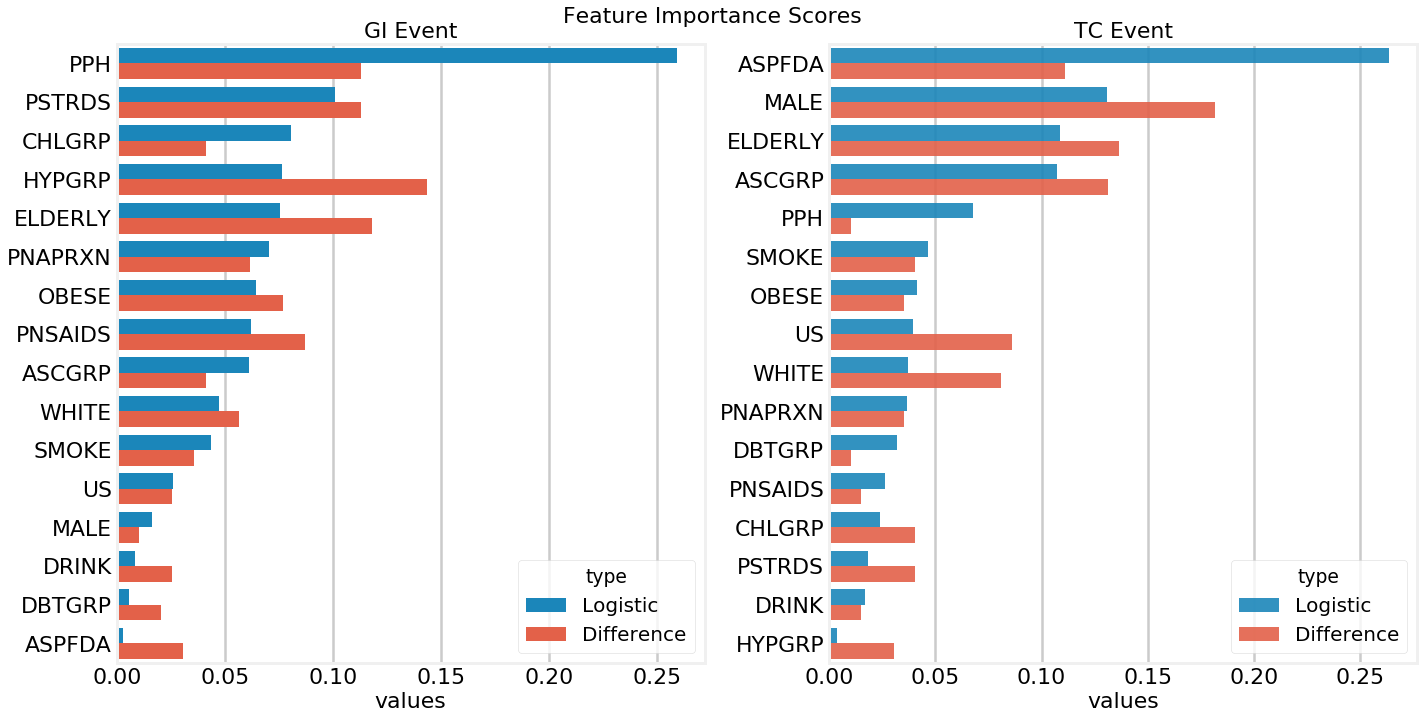

In [38]:
savfig = False

fig, axes = plt.subplots(1, 2, figsize=[20, 10])
ax = axes[0]
temp_df = pd.DataFrame(GI_feat_imp)
sns.barplot(y='feature', x='values', hue='type', data=temp_df,  orient='h', ax=ax, alpha=1)
# ax.legend(False)
ax.set_ylabel('')
ax.set_title("GI Event")


ax = axes[1]
temp_df = pd.DataFrame(TC_feat_imp)
sns.barplot(y='feature', x='values', hue='type', data=temp_df,  orient='h', ax=ax, alpha=0.9)
ax.set_ylabel('')
ax.set_title("TC Event")

plt.suptitle("Feature Importance Scores", y=1.0)

plt.tight_layout()
if savfig:
    plt.savefig("figs/GI_TC_feat_imp.pdf")
plt.show()

### 4.2. Cell overlap plots

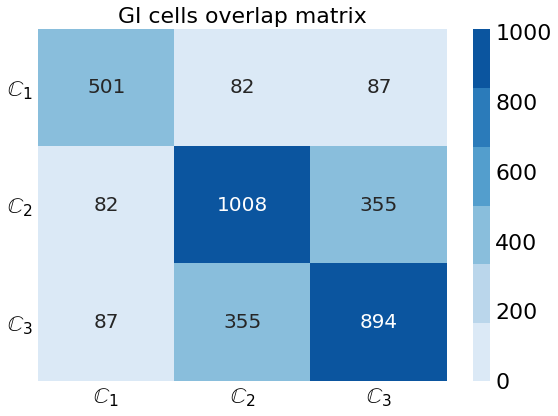

In [42]:
intersection_mat = joblib.load("data_files/GI/GI_cell_overlap_mat")
c = intersection_mat.shape[0]
plt.figure(figsize=[8, 6])
sns.heatmap(intersection_mat, annot = True, fmt = "d", 
            cmap = sns.color_palette("Blues"), annot_kws={'size':20},
            vmin = 0, vmax = intersection_mat.values.max())
cell_ticks = [r'$\mathbb{C}_{%d}$'%(j+1) for j in range(c)]
plt.xticks(np.arange(3)+0.5, cell_ticks)
plt.yticks(np.arange(3)+0.5, cell_ticks, rotation=0)
plt.title(f"{outcome_name} cells overlap matrix")
plt.tight_layout()

if savfig:
    plt.savefig(SAVE_PATH + f"{outcome_name}_cell_heatmap.pdf")
plt.show()

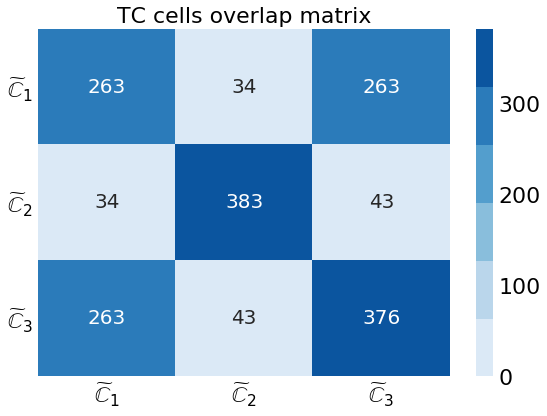

In [43]:
intersection_mat = joblib.load("data_files/cfd_cardio/cfd_cardio_cell_overlap_mat")
c = intersection_mat.shape[0]
plt.figure(figsize=[8, 6])
sns.heatmap(intersection_mat, annot = True, fmt = "d", 
            cmap = sns.color_palette("Blues"), annot_kws={'size':20},
            vmin = 0, vmax = intersection_mat.values.max())
cell_ticks = [r'$\widetilde{\mathbb{C}}_{%d}$'%(j+1) for j in range(c)]
plt.xticks(np.arange(c)+0.5, cell_ticks)
plt.yticks(np.arange(c)+0.5, cell_ticks, rotation=0)
plt.title("TC cells overlap matrix")
plt.tight_layout()

if savfig:
    plt.savefig(SAVE_PATH + f"{outcome_name}_cell_heatmap.pdf")
plt.show()